In [1]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.stats import pointbiserialr
import networkx as nx
from sklearn.cross_decomposition import PLSCanonical


In [2]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [3]:
def matrixplot(data,title):
	plt.figure()
	plt.imshow(data,vmin =-0.5,vmax = 0.5, cmap = 'jet')
	plt.colorbar()
	plt.title(title)
	plt.xticks(range(32),labels = labels,rotation = 'vertical')
	plt.yticks(range(32),labels = labels,rotation = 'horizontal')

In [4]:
def matrixplot(data,title):
	plt.figure()
	plt.imshow(data,vmin =-0.5,vmax = 0.5, cmap = 'jet')
	plt.colorbar()
	plt.title(title)
	plt.xticks(range(32),labels = labels,rotation = 'vertical')
	plt.yticks(range(32),labels = labels,rotation = 'horizontal')


In [5]:
#def generate random graphs 
def gen_graphs(G):
	randG = dict()
	for j in range(len(G)):
		nnodes = G[j].number_of_nodes
		nedges = G[j].number_of_edges
		randG[j] = nx.gnm_random_graph(nnodes,nedges)
	return randG 
	

In [7]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [8]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synchronization','Syncopation']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [9]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [10]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [12]:
hurstdict = loadmat('../Hurst_Behav/H.mat')
hurstdict.keys()
H= hurstdict['H']
H.shape

(144, 2)

In [13]:
#organize hurst exponents 
H_follow_synco = np.zeros(36)
H_lead_synco = np.zeros(36)
H_ind_synco = np.zeros(36)
H_mutual_synco = np.zeros(36)
H_follow_synch = np.zeros(36)
H_lead_synch = np.zeros(36)
H_ind_synch = np.zeros(36)
H_mutual_synch = np.zeros(36)

H_follow_synco[0:18] = H[indices['R_lead_synco_ind'],0]
H_follow_synco[18:36] = H[indices['L_lead_synco_ind'],1]
H_lead_synco[0:18] = H[indices['L_lead_synco_ind'],0]
H_lead_synco[18:36] =H[indices['R_lead_synco_ind'],1]
H_mutual_synco[0:18] = H[indices['Mutual_synco_ind'],0] 
H_mutual_synco[18:36] = H[indices['Mutual_synco_ind'],1]
H_ind_synco[0:18] = H[indices['Uncoupled_synco_ind'],0]
H_ind_synco[18:36] = H[indices['Uncoupled_synco_ind'],1]

H_follow_synch[0:18] = H[indices['R_lead_synch_ind'],0]
H_follow_synch[18:36] = H[indices['L_lead_synch_ind'],1]
H_lead_synch[0:18] = H[indices['L_lead_synch_ind'],0]
H_lead_synch[18:36] =H[indices['R_lead_synch_ind'],1]
H_mutual_synch[0:18] = H[indices['Mutual_synch_ind'],0] 
H_mutual_synch[18:36] = H[indices['Mutual_synch_ind'],1]
H_ind_synch[0:18] = H[indices['Uncoupled_synch_ind'],0]
H_ind_synch[18:36] = H[indices['Uncoupled_synch_ind'],1]

In [14]:

#organize the correlation matrices

R_follow_synco = np.zeros((36,7,32,32))
R_lead_synco = np.zeros((36,7,32,32))
R_ind_synco = np.zeros((36,7,32,32))
R_mutual_synco = np.zeros((36,7,32,32))
R_follow_synch = np.zeros((36,7,32,32))
R_lead_synch = np.zeros((36,7,32,32))
R_ind_synch = np.zeros((36,7,32,32))
R_mutual_synch = np.zeros((36,7,32,32))

R_follow_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
R_follow_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
R_lead_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
R_lead_synco[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
R_mutual_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
R_mutual_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
R_ind_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
R_ind_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

R_follow_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
R_follow_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
R_lead_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
R_lead_synch[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
R_mutual_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
R_mutual_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
R_ind_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
R_ind_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]


In [15]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
        
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]



In [20]:
np.shape(A_mutual_synco)

(36, 7, 32, 32)

In [16]:
r_AH_synco = np.zeros((7,32,32))
r_AH_synch = np.zeros((7,32,32))
p_AH_synco = np.zeros((7,32,32))
p_AH_synch = np.zeros((7,32,32))
for j in range(7):
    for k in range(32):
        for l in range(32):
            r_AH_synco[j,k,l], p_AH_synco[j,k,l]= pointbiserialr(A_mutual_synco[:,j,k,l],H_mutual_synco)
            r_AH_synch[j,k,l], p_AH_synch[j,k,l] = pointbiserialr(A_mutual_synch[:,j,k,l],H_mutual_synch)


c:\Users\zhouz\mne-python\1.3.1_0\envs\mne\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


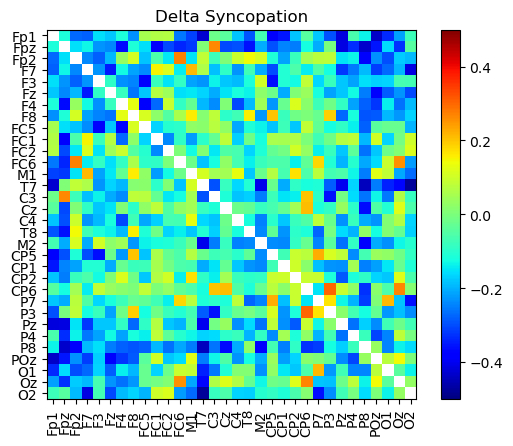

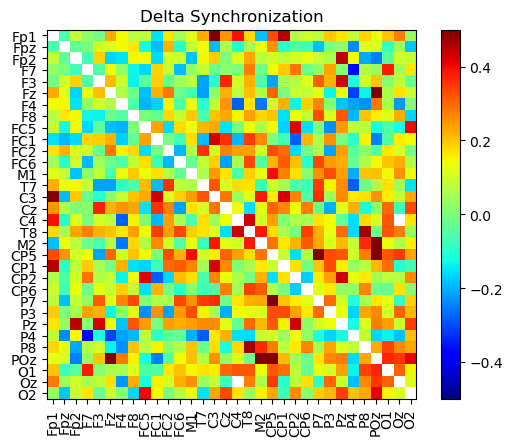

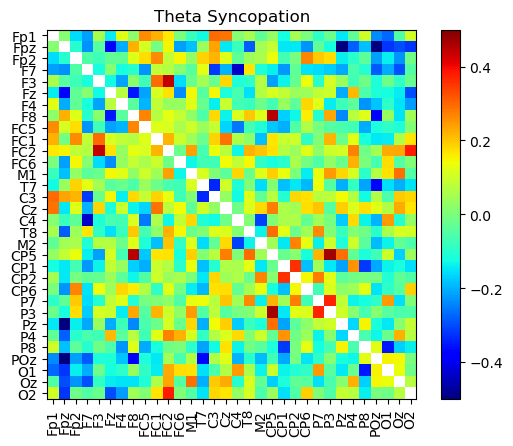

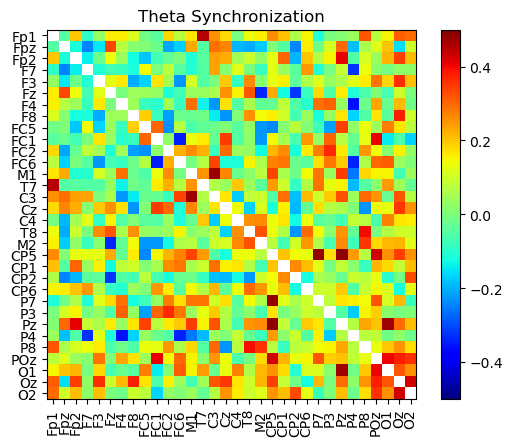

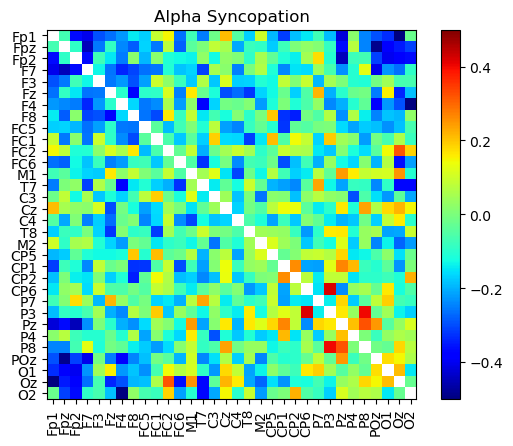

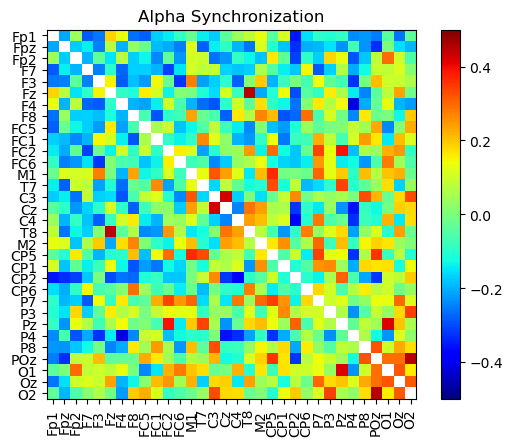

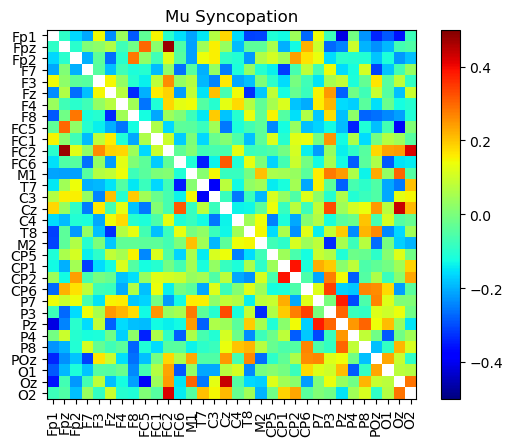

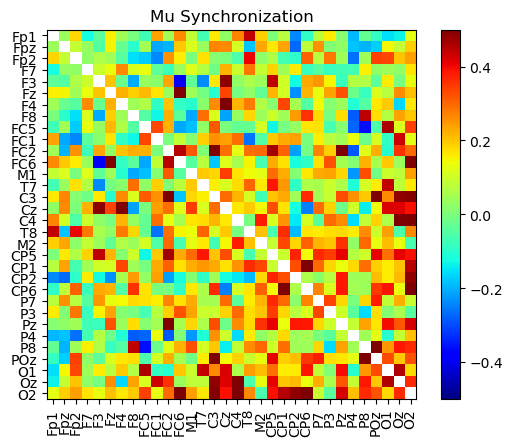

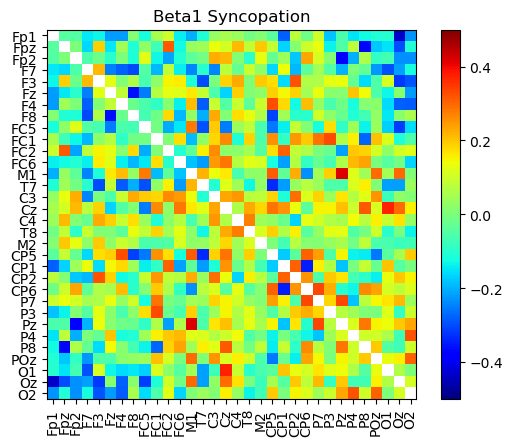

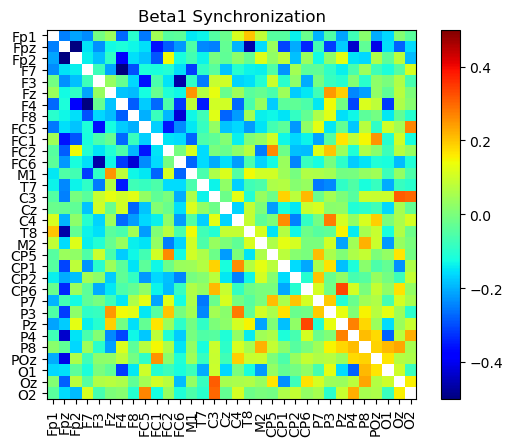

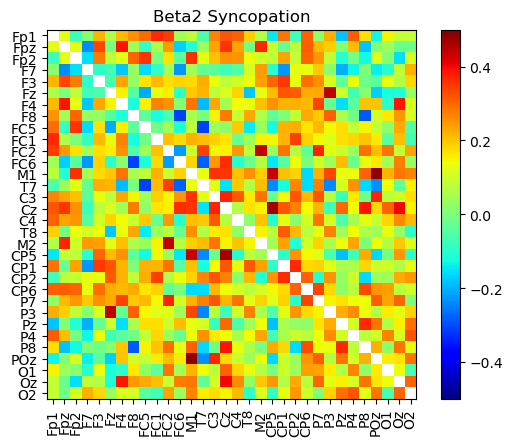

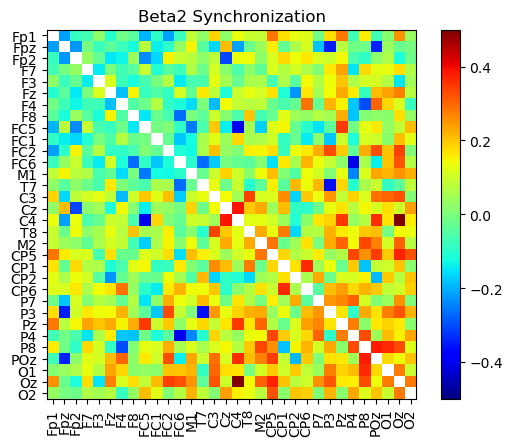

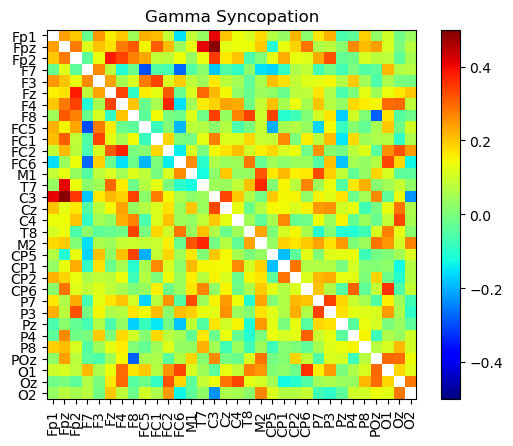

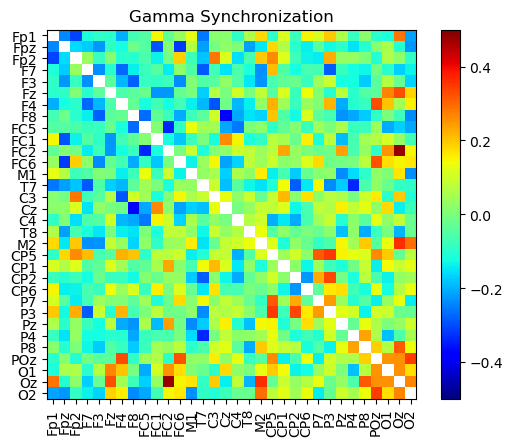

In [72]:
for f in range(7):
    data = r_AH_synco[f,:,:]
    title = band_labels[f]+ ' Syncopation'
    matrixplot(data,title)
    data = r_AH_synch[f,:,:]
    title = band_labels[f]+ ' Synchronization'
    matrixplot(data,title)

    

In [21]:
f=4
G_lead_synco = dict()
G_follow_synco = dict()
G_ind_synco = dict()
G_mutual_synco = dict()

c_lead_synco = np.zeros((36,32))
c_follow_synco = np.zeros((36,32))
c_ind_synco = np.zeros((36,32))
c_mutual_synco = np.zeros((36,32))

d_lead_synco = np.zeros((36,32))
d_follow_synco = np.zeros((36,32))
d_ind_synco = np.zeros((36,32))
d_mutual_synco = np.zeros((36,32))


G_lead_synch = dict()
G_follow_synch = dict()
G_ind_synch = dict()
G_mutual_synch = dict()

c_lead_synch = np.zeros((36,32))
c_follow_synch = np.zeros((36,32))
c_ind_synch = np.zeros((36,32))
c_mutual_synch = np.zeros((36,32))

d_lead_synch = np.zeros((36,32))
d_follow_synch = np.zeros((36,32))
d_ind_synch = np.zeros((36,32))
d_mutual_synch = np.zeros((36,32))

for j in range(36):
	G_lead_synco[j] = nx.from_numpy_array(A_lead_synco[j,f,:,:])
	x = nx.clustering(G_lead_synco[j])
	xd = nx.degree_centrality(G_lead_synco[j])
	G_follow_synco[j] = nx.from_numpy_array(A_follow_synco[j,f,:,:])
	y = nx.clustering(G_follow_synco[j])
	yd = nx.degree_centrality(G_follow_synco[j])
	G_ind_synco[j] = nx.from_numpy_array(A_ind_synco[j,f,:,:])
	z = nx.clustering(G_ind_synco[j])
	zd = nx.degree_centrality(G_ind_synco[j])
	G_mutual_synco[j] = nx.from_numpy_array(A_mutual_synco[j,f,:,:])
	w = nx.clustering(G_mutual_synco[j])
	wd = nx.degree_centrality(G_mutual_synco[j])
	for k in range(32):
		c_lead_synco[j,k] = x[k]
		c_follow_synco[j,k] = y[k]
		c_ind_synco[j,k] = z[k]
		c_mutual_synco[j,k] = w[k]
		d_lead_synco[j,k] = xd[k]
		d_follow_synco[j,k] = yd[k]
		d_ind_synco[j,k] = zd[k]
		d_mutual_synco[j,k] = wd[k]

#dc_ind = (dc_lead+dc_ind)/2


for j in range(36):
	G_lead_synch[j] = nx.from_numpy_array(A_lead_synch[j,f,:,:])
	x = nx.clustering(G_lead_synch[j])
	xd = nx.degree_centrality(G_lead_synch[j])
	G_follow_synch[j] = nx.from_numpy_array(A_follow_synch[j,f,:,:])
	y = nx.clustering(G_follow_synch[j])
	yd = nx.degree_centrality(G_follow_synch[j])
	G_ind_synch[j] = nx.from_numpy_array(A_ind_synch[j,f,:,:])
	z = nx.clustering(G_ind_synch[j])
	zd = nx.degree_centrality(G_ind_synch[j])
	G_mutual_synch[j] = nx.from_numpy_array(A_mutual_synch[j,f,:,:])
	w = nx.clustering(G_mutual_synch[j])
	wd = nx.degree_centrality(G_mutual_synch[j])
	
	for k in range(32):
		c_lead_synch[j,k] = x[k]
		c_follow_synch[j,k] = y[k]
		c_ind_synch[j,k] = z[k]
		c_mutual_synch[j,k] = w[k]
		d_lead_synch[j,k] = xd[k]
		d_follow_synch[j,k] = yd[k]
		d_ind_synch[j,k] = zd[k]
		d_mutual_synch[j,k] = wd[k]

#dc_ind = (dc_lead+dc_ind)/2





In [22]:
from scipy.stats import pearsonr

[0.06555913 0.12622905 0.04368025 0.09841768 0.08571057 0.08833244
 0.13577723 0.08666263 0.45782275 0.01789355 0.07661655 0.28959232
 0.65303757 0.29487129 0.18067593 0.45370395 0.13850905 0.11236606
 0.91312227 0.60937973 0.22155307 0.35142135 0.24711969 0.55824084
 0.63071954 0.74433008 0.26496966 0.86973039 0.3587207  0.94192999
 0.8026568  0.85849337]
[0.25636196 0.27053627 0.23248488 0.73936752 0.26525342 0.19818018
 0.79867633 0.70685508 0.5867925  0.09259695 0.81993146 0.84786383
 0.31888963 0.86699166 0.8274631  0.6089133  0.79995861 0.6635531
 0.645693   0.12203312 0.81219906 0.80955981 0.68875704 0.18360391
 0.81689097 0.78843686 0.29964931 0.51672435 0.74955702 0.58281956
 0.34168502 0.47333997]


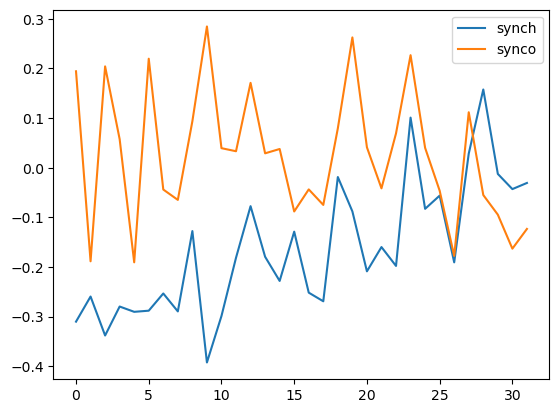

In [23]:
x0 = np.zeros(32)
x1 = np.zeros(32)
p0 = np.zeros(32)
p1 = np.zeros(32)
for j in range(32):
    x0[j],p0[j] = pearsonr(c_mutual_synch[:,j],H_mutual_synch)
    x1[j],p1[j] = pearsonr(c_mutual_synco[:,j],H_mutual_synch) #typo? synco
plt.plot(x0)
plt.plot(x1)
plt.legend(('synch','synco'))
print(p0)
print(p1)